# Exploratody data analysis

In [1]:
import os 
import sys
import glob
import pickle
import pyprind
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

import utils
import data_prep as prep
import train_select as ts

In [2]:
random_state = 42

In [3]:
npi = prep.prepare_npi(prep.npi_url, dropna=True, add_new_features=True, verbose=True)

INFO Data set PartD_Prescriber_PUF_NPI_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_15.zip
INFO successfully downloaded and uncompressed
INFO Data cleaning completed
INFO New features are added
INFO prescriber summary dataset is prepared and
INFO saved at dataset/PartD_Prescriber_PUF_NPI_15_clean.csv


# Descriptive statistics
#### 1. op_prescriber

In [4]:
npi.op_prescriber.value_counts() 

True     438183
False    192807
Name: op_prescriber, dtype: int64

#### 2. Average days op_prescribed if  opioid was prescribed

In [5]:
npi['avg_op_day_supply'].describe()

count    630990.000000
mean         33.536462
std          52.416996
min           0.000000
25%           0.000000
50%           6.406250
75%          51.730509
max         695.891566
Name: avg_op_day_supply, dtype: float64

#### 3. op_longer

In [6]:
npi.op_longer.value_counts()

False    533997
True      96993
Name: op_longer, dtype: int64

In [7]:
ntl, drug_name_dict = prep.get_drug_name_dict(threshold=500)
non_op_names, op_names = prep.get_drug_names(ntl, drug_name_dict, 
                                        n_other_drugs=prep.n_other_drugs, 
                                        random_state=random_state)

INFO Data set PartD_Prescriber_PUF_Drug_Ntl_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_Drug_Ntl_15.zip
INFO successfully downloaded and uncompressed


In [8]:
for k in drug_name_dict.keys():
    print("{}: {}".format(k, len(drug_name_dict[k])))

others: 951
Antibiotic Drug Flag: 78
Antipsychotic Drug Flag: 28
High Risk Medication (HRM) Drug Flag: 68
Opioid Drug Flag: 29


In [9]:
tmp = ntl.loc[ntl['Opioid Drug Flag'] == 'Y ', :]
list(tmp.loc[tmp['High Risk Medication (HRM) Drug Flag']=='Y ', 'Generic Name'].unique())

['CODEINE/BUTALBITAL/ASA/CAFFEIN ',
 'BUTALBIT/ACETAMIN/CAFF/CODEINE ',
 'CODEINE/CARISOPRODOL/ASPIRIN ',
 'MEPERIDINE HCL ',
 'MEPERIDINE HCL/PF ',
 'PENTAZOCINE HCL/NALOXONE HCL ']

## Make small dataset for EDA

In [16]:
drugs = prep.download_drugs()

INFO Data set PartD_Prescriber_PUF_NPI_DRUG_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_DRUG_15.zip
INFO successfully downloaded and uncompressed


In [17]:
def clean_drug_chunks(drugs, npi, non_op_names, op_names, scale=False, chunk_size=prep.chunk_size):

    small = drugs.get_chunk(chunk_size)
    small = small.loc[small['bene_count'] > 0, :]
    small[ 'avg_day_supply' ] = small[ 'total_day_supply' ] / small[ 'bene_count' ]
    small[ 'generic_name' ] = utils.clean_txt(small[ 'generic_name' ])

    cols_to_keep = [ 'npi', 'generic_name', 'avg_day_supply' ]
    small = small.loc[ :, cols_to_keep ]
    small = small.set_index('npi')

    wide_table = pd.crosstab(index=small.index,
                             columns=small[ 'generic_name' ],
                             values=small[ 'avg_day_supply' ],
                             aggfunc=np.mean)

    drug_names = set(op_names + non_op_names)
    wide_table = wide_table.loc[ :, drug_names ]
    wide_table = wide_table.fillna(0)
    wide_table.index.name = 'npi'

    # =========== feature scaling ==========
    if scale:
        wide_table = wide_table.apply(func=prep.minmax_scaler, axis=1)

    # joined by prescriber summary data
    npi_small = npi.copy()
    cols_to_keep = [ 'gender',
                     'state',
                     'specialty',
                     'medicare_status',
                     'op_prescriber',
                     'op_longer' ]
    npi_small = npi_small.loc[ :, cols_to_keep ]
    wide_table = wide_table.join(npi_small, how='inner')

    return wide_table

We'll use batches 0 through 16, except batch 2 in the training set for exploratory data analysis.

In [19]:
chunk_size = prep.chunk_size  # 100,000
eda_df = None
batch_to_pass = [5, 16]
for i in range(17):
    if i in batch_to_pass: 
        pass
    
    else:
        tmp_df = clean_drug_chunks(drugs, npi, non_op_names, op_names)
        if eda_df is None:
            eda_df = tmp_df
        else:
            eda_df = pd.concat([eda_df, tmp_df])

In [20]:
print(eda_df.shape)
#list(eda_df.columns)

(32145, 435)


In [21]:
with open('dataset/eda.pickle', 'wb') as f:
    pickle.dump(eda_df, f)
    f.close()

# Specialty vs avg day of opioid supply

In [22]:
npi_op = npi.loc[:, ['op_day_supply', 'avg_op_day_supply']]
df = eda_df.join(npi_op, how='inner')

In [25]:
tmp = df['avg_op_day_supply'].groupby(df['specialty']).describe().unstack()
misc = tmp.loc[tmp['count'] < 10, :].index
df = df.loc[~df['specialty'].isin(misc), :]
grouped_spec = df['avg_op_day_supply'].groupby(df['specialty'])
grouped_spec_mean = grouped_spec.mean().sort_values(ascending=False)
top20 = grouped_spec_mean.index[:20]
top40 = grouped_spec_mean.index[:40]
top63 = grouped_spec_mean.index[:63]

In [31]:
total_spec = df['op_day_supply'].groupby(df['specialty']).sum().sort_values(ascending=False)
(total_spec / total_spec.sum()).iloc[:4].sum()

0.69714152815162012

#### pandas 

In [177]:
#eda_df.boxplot('avg_op_day_supply', by='specialty')

#### plotly

In [178]:
import plotly.plotly as py
import plotly.graph_objs as go
    
data = []
for name, group in grouped_spec:
    if name in top20:
        trace = go.Box(x=group, name=name)
        data.append(trace)
    
#py.iplot(data)

#### seaborn

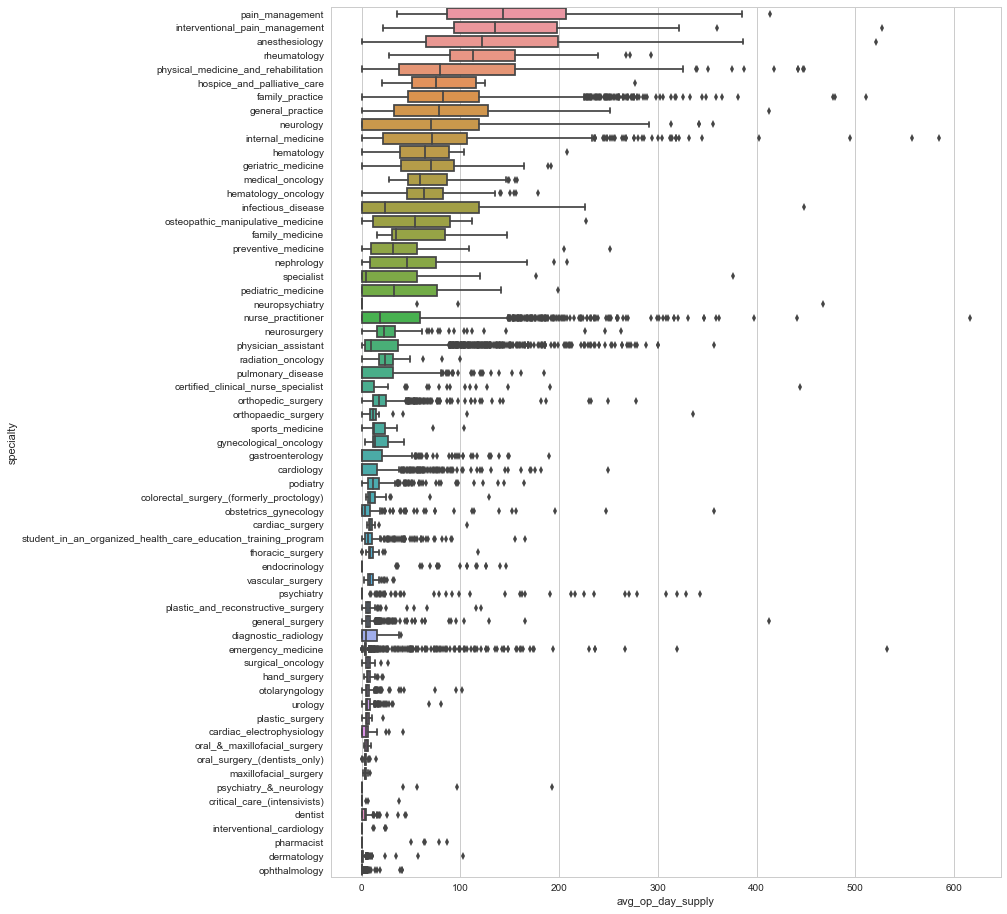

In [33]:
sns.set(style='whitegrid', rc={"figure.figsize": (12, 16)})
df_small = df.loc[:, ['specialty', 'avg_op_day_supply']]
df_small = df_small.loc[df['specialty'].isin(top63), :]
sns.boxplot(data=df_small, y='specialty', x='avg_op_day_supply', order=top63)
plt.show()

In [34]:
tmp = df_small.groupby(df_small['specialty']).describe().unstack()
tmp.loc[top40, ]

avg_op_day_supply  \
                                                               count   
specialty                                                              
pain_management                                                 83.0   
interventional_pain_management                                  92.0   
anesthesiology                                                 150.0   
rheumatology                                                   194.0   
physical_medicine_and_rehabilitation                           307.0   
hospice_and_palliative_care                                     19.0   
family_practice                                               4903.0   
general_practice                                               227.0   
neurology                                                      305.0   
internal_medicine                                             3871.0   
hematology                                                      12.0   
geriatric_medicine                                              89.0   
medical_oncology                                               116.0   
hematology_oncology                                            294.0   
infectious_disease                                              58.0   
osteopathic_manipulative_medicine                               18.0   
family_medicine                                                 10.0   
preventive_medicine                                             15.0   
nephrology                                                     182.0   
specialist                                                      23.0   
pediatric_medicine                                              56.0   
neuropsychiatry                                                 15.0   
nurse_practitioner                                            4019.0   
neurosurgery                                                   155.0   
physician_assistant                                           3207.0   
radiation_oncology                                              61.0   
pulmonary_disease                                              143.0   
certified_clinical_nurse_specialist                             82.0   
orthopedic_surgery                                            1178.0   
orthopaedic_surgery                                             42.0   
sports_medicine                                                 25.0   
gynecological_oncology                                          36.0   
gastroenterology                                               225.0   
cardiology                                                     432.0   
podiatry                                                       481.0   
colorectal_surgery_(formerly_proctology)                        58.0   
obstetrics_gynecology                                          260.0   
cardiac_surgery                                                 33.0   
student_in_an_organized_health_care_education_t...             346.0   
thoracic_surgery                                                67.0   

                                                                            \
                                                          mean         std   
specialty                                                                    
pain_management                                     157.951822   86.314548   
interventional_pain_management                      151.230924   86.306679   
anesthesiology                                      143.684758   99.491988   
rheumatology                                        121.896958   50.877996   
physical_medicine_and_rehabilitation                111.454937   97.673919   
hospice_and_palliative_care                          89.111500   57.016977   
family_practice                                      87.213923   56.280299   
general_practice                                     82.606906   61.840072   
neurology                                            76.884271   74.889207   
internal_medicine 

## Overdose deaths by states

In [35]:
num_pres = eda_df.groupby('state').size()
num_longer = eda_df['op_longer'].groupby(eda_df['state']).sum()
ratio_pres_longer = (num_longer / num_pres).sort_values(ascending=False)
tmp = pd.concat([num_pres, num_longer, ratio_pres_longer], axis = 1)
tmp.columns = ['num_prescriber', 'num_longer', 'ratio_of_longer']
tmp['state'] = tmp.index
tmp = tmp.sort_values(by='ratio_of_longer', ascending=False)

In [36]:
overdose = pd.read_csv("dataset/overdoses.csv", thousands = ",")
overdose = overdose.set_index('Abbrev')
overdose.Deaths = pd.to_numeric(overdose.Deaths)
overdose.Population = pd.to_numeric(overdose.Population)
overdose['death_per_cap'] = 100000 * overdose['Deaths'] / overdose['Population']

In [37]:
overdose = pd.concat([overdose, tmp], axis = 1)

In [38]:
overdose = overdose.sort_values(by='ratio_of_longer', ascending=False)
overdose

,State,Population,Deaths,death_per_cap,num_prescriber,num_longer,ratio_of_longer,state
VT,Vermont,626630.0,83.0,13.245456,103,33.0,0.320388,VT
AK,Alaska,735132.0,124.0,16.867719,51,16.0,0.313725,AK
MT,Montana,1015165.0,125.0,12.313269,138,40.0,0.289855,MT
WV,West Virginia,1854304.0,627.0,33.813226,260,71.0,0.273077,WV
NM,New Mexico,2085287.0,547.0,26.231401,203,54.0,0.266010,NM
IA,Iowa,3090416.0,264.0,8.542539,358,93.0,0.259777,IA
IN,Indiana,6570902.0,1172.0,17.836212,711,182.0,0.255977,IN
ID,Idaho,1612136.0,212.0,13.150255,213,54.0,0.253521,ID
KS,Kansas,2893957.0,332.0,11.472182,330,79.0,0.239394,KS
OR,Oregon,3930065.0,522.0,13.282223,528,126.0,0.238636,OR


In [39]:
overdose['ratio_of_longer'].mean()

0.20215657377951199

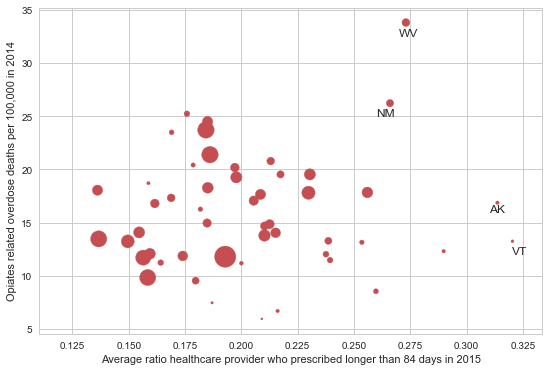

In [42]:
plt.figure(figsize=(9, 6))
s = .1 * overdose['Deaths'] 
plt.scatter(y=overdose['death_per_cap'], x=overdose['ratio_of_longer'], 
           s = s , 
            c = 'r')
plt.text(0.27, 32.5, 'WV')
plt.text(0.26, 25, 'NM')
plt.text(0.32, 12, 'VT')
plt.text(0.31, 16, 'AK')
plt.xlabel('Average ratio healthcare provider who prescribed longer than 84 days in 2015')
plt.ylabel('Opiates related overdose deaths per 100,000 in 2014')
#plt.savefig('assets/overdose_vs_ratio.png')
plt.show()

# Specialty vs opioids

In [151]:
cols_to_keep = ['specialty', 'op_longer'] + op_names
small = eda_df.loc[:, cols_to_keep]
small = small.loc[:, (small != 0).any(axis=0)]
small.shape

(32145, 21)

In [152]:
#freq_specialty = list(small.specialty.value_counts(ascending=False).index[:25])
small = small.loc[small['specialty'].isin(top40), :]
grouped = small.groupby('specialty').corrwith(small['op_longer'])
grouped = grouped.dropna(how='all', axis=1)
grouped = grouped.drop('op_longer', 1)

In [153]:
grouped

,acetaminophen_with_codeine,buprenorphine,buprenorphine_hcl,butalbit_acetamin_caff_codeine,fentanyl,hydrocodone_acetaminophen,hydrocodone_bitartrate,hydrocodone_ibuprofen,hydromorphone_hcl,meperidine_hcl,methadone_hcl,morphine_sulfate,oxycodone_hcl,oxycodone_hcl_acetaminophen,oxymorphone_hcl,pentazocine_hcl_naloxone_hcl,tapentadol_hcl,tramadol_hcl,tramadol_hcl_acetaminophen
specialty,,,,,,,,,,,,,,,,,,,
anesthesiology,0.159845,0.105568,NaN,NaN,0.387413,0.542947,0.081584,NaN,0.233646,NaN,0.325078,0.438543,0.409299,0.424583,0.162921,NaN,0.081059,0.437382,0.004154
cardiac_surgery,0.991555,NaN,NaN,NaN,NaN,0.976417,NaN,NaN,NaN,NaN,NaN,NaN,-0.031250,-0.153938,NaN,NaN,NaN,0.980616,NaN
cardiology,0.243653,NaN,NaN,NaN,0.207942,0.537308,NaN,NaN,NaN,NaN,0.207942,NaN,0.207942,0.535130,NaN,NaN,NaN,0.390260,-0.011158
certified_clinical_nurse_specialist,0.263027,-0.039014,-0.039014,NaN,0.436269,0.677112,NaN,NaN,0.526146,NaN,0.533213,0.500927,0.508848,0.558512,NaN,NaN,NaN,0.424626,NaN
colorectal_surgery_(formerly_proctology),NaN,NaN,NaN,NaN,NaN,0.758277,NaN,NaN,-0.017544,NaN,NaN,NaN,-0.043186,0.840490,NaN,NaN,NaN,-0.024255,NaN
family_medicine,NaN,NaN,NaN,NaN,0.509175,0.908034,NaN,NaN,NaN,NaN,NaN,0.007656,0.509175,0.690113,NaN,NaN,NaN,0.509175,NaN
family_practice,0.137654,0.016112,0.009528,0.014627,0.168726,0.604909,NaN,0.021366,0.066972,NaN,0.068009,0.146737,0.271439,0.354763,0.030625,NaN,0.014627,0.449026,0.046246
gastroenterology,0.226582,NaN,NaN,NaN,NaN,0.246516,NaN,NaN,0.226582,NaN,0.226582,0.226582,0.226582,0.160388,NaN,NaN,NaN,0.250165,NaN
general_practice,0.226729,NaN,NaN,NaN,0.146231,0.627518,NaN,NaN,0.116833,NaN,0.084215,0.168841,0.262800,0.305928,NaN,NaN,NaN,0.440045,-0.015830


In [154]:
grouped.mean(axis=0).sort_values(ascending=False)

hydrocodone_acetaminophen         0.551665
oxycodone_hcl_acetaminophen       0.362704
tramadol_hcl                      0.338786
morphine_sulfate                  0.319281
oxycodone_hcl                     0.295881
fentanyl                          0.269979
methadone_hcl                     0.244464
acetaminophen_with_codeine        0.199823
hydromorphone_hcl                 0.186701
oxymorphone_hcl                   0.176988
buprenorphine                     0.096216
tapentadol_hcl                    0.068940
hydrocodone_bitartrate            0.065746
buprenorphine_hcl                 0.029258
hydrocodone_ibuprofen             0.025858
tramadol_hcl_acetaminophen        0.022853
butalbit_acetamin_caff_codeine    0.014627
pentazocine_hcl_naloxone_hcl     -0.003831
meperidine_hcl                   -0.005936
dtype: float64

In [155]:
grouped.mean(axis=1).sort_values(ascending=False)

specialty
neuropsychiatry                                                   0.681385
radiation_oncology                                                0.616476
cardiac_surgery                                                   0.552680
family_medicine                                                   0.522221
neurosurgery                                                      0.429242
certified_clinical_nurse_specialist                               0.395514
obstetrics_gynecology                                             0.389441
hematology                                                        0.381177
specialist                                                        0.353248
hospice_and_palliative_care                                       0.344534
pediatric_medicine                                                0.343200
preventive_medicine                                               0.340118
infectious_disease                                                0.326383
orthopaedic_sur

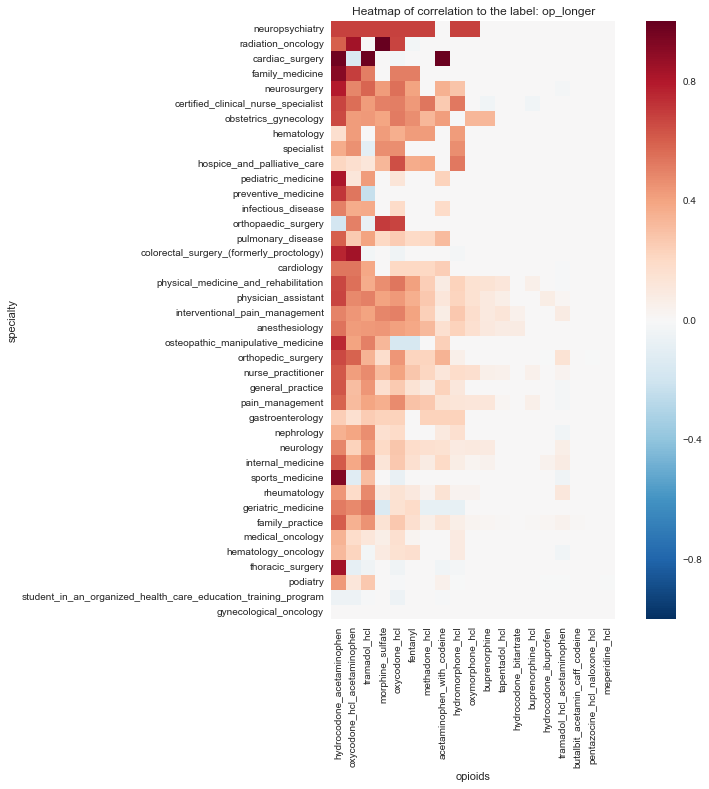

In [157]:
plt.figure(figsize=(11, 11))
sorted_op = grouped.mean(axis=0).sort_values(ascending=False).index
sorted_spec = grouped.mean(axis=1).sort_values(ascending=False).index
grouped = grouped.loc[:, sorted_op]
grouped = grouped.loc[sorted_spec, :]
g = sns.heatmap(grouped.fillna(0), square=True)
#plt.savefig('assets/clustermap_specialty_vs_op.png', orientation='landscape', dpi=199)
plt.title('Heatmap of correlation to the label: op_longer')
plt.ylabel('specialty')
plt.xlabel('opioids')
plt.show()

# Non-opioid vs Op_longer

#### Antibiotics

In [98]:
drug_name_dict.keys()

dict_keys(['others', 'Antibiotic Drug Flag', 'Antipsychotic Drug Flag', 'High Risk Medication (HRM) Drug Flag', 'Opioid Drug Flag'])

In [104]:
antibiotic_names = drug_name_dict['Antibiotic Drug Flag'] + ['op_longer', 'specialty']
antibiotic = eda_df.loc[:, antibiotic_names]
antibiotic = antibiotic.loc[antibiotic['specialty'].isin(top20), :]
antibiotic_corr = antibiotic.groupby('specialty').corrwith(antibiotic['op_longer'])
antibiotic_corr = antibiotic_corr.dropna(how='all', axis=1)
antibiotic_corr = antibiotic_corr.drop('op_longer', 1)

In [110]:
antibiotic_corr

,amikacin_sulfate,amoxicillin,amoxicillin_potassium_clav,ampicillin_trihydrate,azithromycin,cefaclor,cefadroxil,cefazolin_sodium,cefdinir,cefepime_hcl,cefixime,cefpodoxime_proxetil,cefprozil,ceftaroline_fosamil_acetate,ceftriaxone_sodium,cefuroxime_axetil,cephalexin,ciprofloxacin_hcl,clarithromycin,clindamycin_hcl,clindamycin_phosphate,daptomycin,dicloxacillin_sodium,doxycycline_hyclate,doxycycline_monohydrate,ertapenem_sodium,erythromycin_base,erythromycin_ethylsuccinate,fosfomycin_tromethamine,gentamicin_sulfate,levofloxacin,linezolid,meropenem,metronidazole,minocycline_hcl,moxifloxacin_hcl,nitrofurantoin_macrocrystal,nitrofurantoin_monohyd_m_cryst,ofloxacin,penicillin_v_potassium,rifaximin,sulfamethoxazole_trimethoprim,tigecycline,trimethoprim,vancomycin_hcl
specialty,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
anesthesiology,NaN,-0.158880,NaN,NaN,0.018716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020815,-0.112465,NaN,NaN,NaN,NaN,NaN,-0.112465,NaN,NaN,NaN,NaN,NaN,NaN,-0.112465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112465,NaN,NaN,NaN
family_medicine,NaN,0.509175,0.509175,NaN,0.761242,NaN,NaN,NaN,0.509175,NaN,NaN,NaN,NaN,NaN,0.509175,0.509175,0.758484,0.509175,NaN,0.509175,NaN,NaN,NaN,0.509175,NaN,NaN,NaN,NaN,NaN,NaN,0.587632,NaN,NaN,0.509175,NaN,NaN,NaN,0.509175,NaN,NaN,NaN,0.755590,NaN,NaN,0.509175
family_practice,0.020006,0.170990,0.130536,0.018182,0.200840,0.001986,-0.001340,NaN,0.086502,NaN,NaN,0.013621,0.035451,NaN,0.066475,0.078298,0.174009,0.230697,0.020168,0.063263,-0.011548,NaN,0.014627,0.109416,0.019128,0.001946,0.004174,NaN,NaN,0.054765,0.178509,NaN,NaN,0.100953,0.028102,0.018677,0.054713,0.106791,-0.001280,0.010540,0.014627,0.208794,NaN,0.024345,-0.003040
general_practice,NaN,0.166354,0.121651,0.071702,0.293668,NaN,0.069667,NaN,0.065087,NaN,NaN,NaN,-0.061711,NaN,0.138910,-0.008511,0.227007,0.173946,0.071702,0.078813,NaN,NaN,NaN,0.056024,-0.104902,NaN,-0.068778,NaN,NaN,-0.024883,0.161368,NaN,NaN,0.142278,-0.000911,-0.017462,0.079445,0.095721,-0.061711,-0.061711,NaN,0.286828,NaN,NaN,NaN
geriatric_medicine,NaN,0.322109,0.146991,0.186956,0.238629,NaN,NaN,NaN,0.140839,NaN,NaN,NaN,NaN,NaN,0.013523,0.132963,0.055588,0.103039,NaN,0.178028,NaN,NaN,NaN,0.184432,-0.008169,0.135582,0.106162,NaN,NaN,-0.043922,0.165440,NaN,NaN,-0.023290,NaN,0.024837,0.017410,0.066549,0.135582,NaN,NaN,0.305021,NaN,NaN,-0.083814
hematology,NaN,0.426401,NaN,NaN,-0.213201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426401,NaN,-0.213201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.604931,NaN,NaN,NaN
hematology_oncology,NaN,0.065283,-0.063861,NaN,0.070960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064703,-0.029807,-0.031432,NaN,NaN,NaN,NaN,0.145201,NaN,NaN,NaN,NaN,NaN,NaN,-0.041675,NaN,NaN,NaN,NaN,-0.031432,NaN,-0.031432,NaN,NaN,NaN,0.021488,NaN,NaN,NaN
hospice_and_palliative_care,NaN,NaN,-0.223607,NaN,0.023895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.223607,NaN,NaN,NaN,NaN,NaN,NaN,-0.090150,NaN,NaN,NaN,NaN,NaN,NaN,-0.223607,NaN,NaN,NaN,-0.318779,NaN,NaN,NaN
infectious_disease,NaN,-0.054007,0.005083,NaN,0.149294,NaN,-0.103012,NaN,NaN,-0.092450,NaN,NaN,NaN,0.189766,-0.177659,0.188453,-0.264053,-0.118603,NaN,-0.008426,NaN,-0.09245,-0.092450,-0.053389,NaN,0.109541,NaN,NaN,NaN,NaN,0.165529,NaN,NaN,-0.159062,-0.107224,-0.092450,NaN,NaN,NaN,NaN,NaN,0.255773,0.189766,NaN,-0.063683


In [107]:
antibiotic_corr.mean(axis=0).sort_values(ascending=False)

ceftaroline_fosamil_acetate       0.189766
tigecycline                       0.189766
azithromycin                      0.184421
cefdinir                          0.137364
amoxicillin                       0.125428
sulfamethoxazole_trimethoprim     0.124425
cefuroxime_axetil                 0.100669
amoxicillin_potassium_clav        0.099139
ceftriaxone_sodium                0.098418
metronidazole                     0.082626
clindamycin_hcl                   0.082524
vancomycin_hcl                    0.082094
nitrofurantoin_monohyd_m_cryst    0.074261
ciprofloxacin_hcl                 0.070394
levofloxacin                      0.061886
ampicillin_trihydrate             0.056736
doxycycline_hyclate               0.051589
ertapenem_sodium                  0.043841
cephalexin                        0.043197
nitrofurantoin_macrocrystal       0.032058
clarithromycin                    0.027823
cefixime                          0.027352
ofloxacin                         0.021818
trimethopri

#### Antipsychotic


In [111]:
antipsy_names = drug_name_dict['Antipsychotic Drug Flag'] + ['op_longer', 'specialty']
antipsy = eda_df.loc[:, antipsy_names]
antipsy = antipsy.loc[antipsy['specialty'].isin(top20), :]
antipsy_corr = antipsy.groupby('specialty').corrwith(antipsy['op_longer'])
antipsy_corr = antipsy_corr.dropna(how='all', axis=1)
antipsy_corr = antipsy_corr.drop('op_longer', 1)

In [112]:
antipsy_corr

,aripiprazole,clozapine,haloperidol,haloperidol_decanoate,haloperidol_lactate,lurasidone_hcl,olanzapine,paliperidone_palmitate,perphenazine,quetiapine_fumarate,risperidone,risperidone_microspheres,ziprasidone_hcl,ziprasidone_mesylate
specialty,,,,,,,,,,,,,,
anesthesiology,0.059675,NaN,0.059675,NaN,NaN,NaN,0.059675,NaN,NaN,0.083860,NaN,NaN,0.059675,NaN
family_medicine,NaN,NaN,NaN,NaN,NaN,NaN,0.509175,NaN,NaN,0.509175,NaN,NaN,NaN,NaN
family_practice,0.037755,0.014627,0.033447,0.014627,0.020493,0.020508,0.073203,0.014627,NaN,0.146293,0.103770,0.019246,0.028706,NaN
general_practice,0.124389,NaN,-0.000161,NaN,NaN,NaN,0.133350,NaN,NaN,0.192240,0.116350,NaN,NaN,NaN
geriatric_medicine,-0.083814,NaN,-0.123214,-0.083814,-0.031849,NaN,-0.109097,NaN,NaN,0.147613,0.066708,NaN,NaN,NaN
hematology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hematology_oncology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospice_and_palliative_care,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.316114,-0.223607,NaN,NaN,NaN
infectious_disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.092450,NaN,NaN,NaN,NaN


In [138]:
others_names = drug_name_dict['others'] + ['op_longer', 'specialty']
others = eda_df.loc[:, others_names]
others = others.dropna(axis=1)

others = others.loc[others['specialty'].isin(top40), :]
others_corr = others.groupby('specialty').corrwith(others['op_longer'])
others_corr = others_corr.dropna(how='all', axis=1)
others_corr = others_corr.drop('op_longer', 1)

In [139]:
others_corr.mean(axis=0).sort_values(ascending=False)

gabapentin                        0.422195
alprazolam                        0.371581
lisinopril                        0.309627
levothyroxine_sodium              0.309457
omeprazole                        0.307860
hydrochlorothiazide               0.300905
pregabalin                        0.300822
amlodipine_besylate               0.299352
potassium_chloride                0.286025
tizanidine_hcl                    0.284561
metformin_hcl                     0.281095
albuterol_sulfate                 0.270271
fluticasone_propionate            0.267746
furosemide                        0.263874
metoprolol_succinate              0.257598
ibuprofen                         0.253859
losartan_potassium                0.252858
atorvastatin_calcium              0.250702
diazepam                          0.242848
meloxicam                         0.233220
lorazepam                         0.227172
pravastatin_sodium                0.220221
duloxetine_hcl                    0.218873
atenolol   

In [160]:
others_small = others_corr.dropna(thresh=len(others_corr) - 15, axis=1)
sorted_name = others_small.mean(axis=0).sort_values(ascending=False).index
sorted_spec = others_small.mean(axis=1).sort_values(ascending=False).index
others_small = others_small.loc[sorted_spec, :]
others_small = others_small.loc[:, sorted_name]

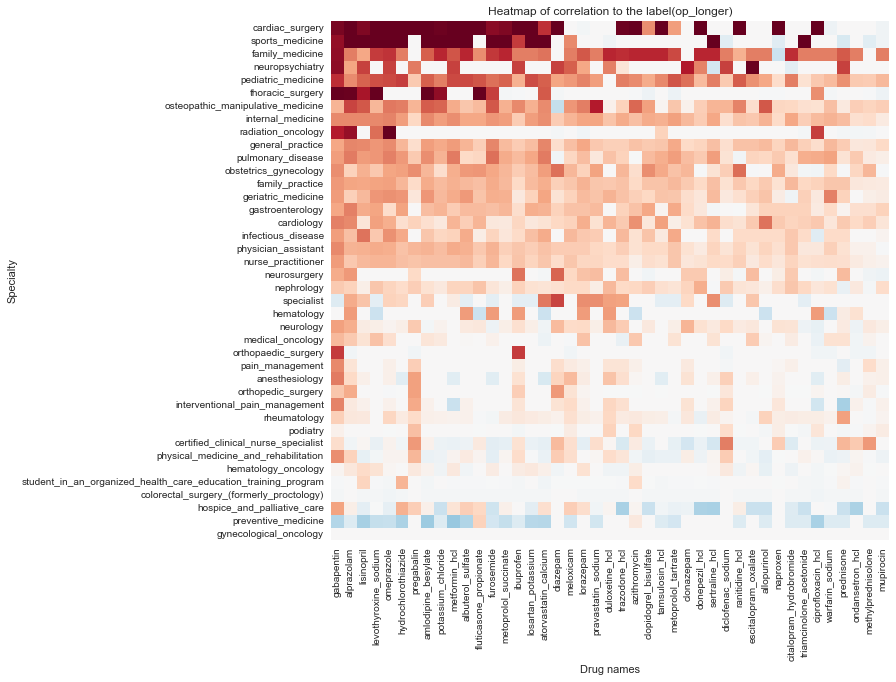

In [161]:
plt.figure(figsize=(10, 10))
sns.heatmap(others_small.fillna(0), square=True, cbar=False)
plt.title('Heatmap of correlation to the label(op_longer)')
plt.xlabel('Drug names')
plt.ylabel('Specialty')
plt.show()